### Plot computation results (computation time vs. number of files) for all tested cases (instances + configurations).

In [107]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()

**Load and prep data**

In [10]:
compresults = pd.read_csv('dscale_computation_results_all.csv')
compresults

,n_workers,threads_per_worker,n_files,compute_time_seconds,ec2_type
0,1,1,1,14,c6i.32xlarge
1,30,1,1,14,c6i.32xlarge
2,30,1,10,29,c6i.32xlarge
3,30,1,100,107,c6i.32xlarge
4,30,1,1000,966,c6i.32xlarge
5,32,1,1,29,p2.8xlarge
6,32,1,10,36,p2.8xlarge
7,32,1,100,179,p2.8xlarge
8,32,1,1000,1580,p2.8xlarge
9,24,1,1,28,r5.12xlarge


In [16]:
# Drop some un-needed runs:
    # (ran with 24 workers/48 threads rather than 48 workers/48 threads)
i_drop = compresults[(compresults['ec2_type']=='r5n.12xlarge') & (compresults['n_workers']==24)].index
compresults = compresults.drop(i_drop)
    # (don't need r5.12xlarge run at half capacity)
i_drop = compresults[(compresults['ec2_type']=='r5.12xlarge') & (compresults['n_workers']==24) & (compresults['threads_per_worker']==1)].index
compresults = compresults.drop(i_drop)

In [17]:
# Average over multiple trials of any configuration:
groupkeys = ['ec2_type', 'n_workers', 'threads_per_worker', 'n_files']
compresults_mean = compresults.groupby(by=groupkeys, group_keys=True, as_index=False).mean()

In [18]:
# Split rows by sequential vs. parallel computing runs:
sequential = compresults_mean.loc[compresults_mean['n_workers']==1]
parallel = compresults_mean.drop(compresults_mean[compresults_mean['n_workers']==1].index)

**Plot**

First, get estimate of how much time it would have taken to process 1000 files in sequential. Estimate this using mean computation time per file over the 1, 10, and 100 file runs.

In [19]:
comptimeperfile_seq = np.mean(sequential['compute_time_seconds']/sequential['n_files'])
print(comptimeperfile_seq*1000/3600, 'hours')

6.36 hours


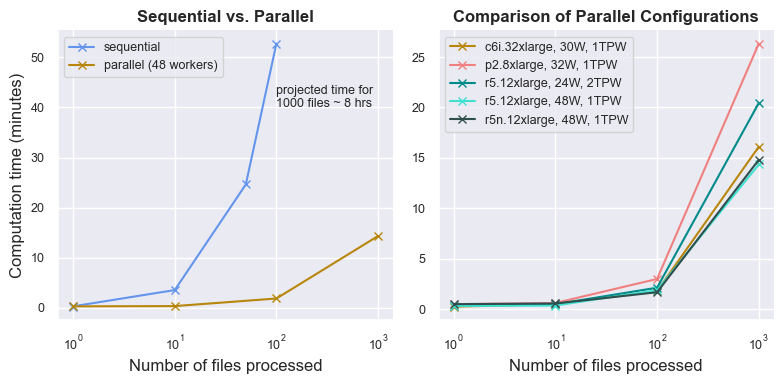

In [106]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), layout='tight')


# Sequential vs. parallel plot
#---------------------------------------------------------------
parcase1 = parallel.loc[
    (parallel['ec2_type']=='r5.12xlarge') &
    (parallel['n_workers']==48) 
    ]

kwargs = {'linestyle':'-', 'marker':'x'}


axes[0].plot(sequential['n_files'], sequential['compute_time_seconds']/60, label='sequential', color='cornflowerblue', **kwargs)
axes[0].plot(parcase1['n_files'], parcase1['compute_time_seconds']/60, label='parallel (48 workers)', color='darkgoldenrod', **kwargs)

axes[0].set_xscale('log')
axes[0].legend(fontsize=9)
axes[0].set_title('Sequential vs. Parallel', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of files processed', fontsize=12)
axes[0].set_ylabel('Computation time (minutes)', fontsize=12)
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].tick_params(axis='both', which='major', labelsize=9)

axes[0].text(100, 40, 'projected time for \n1000 files ~ 8 hrs', fontsize=9)
#---------------------------------------------------------------


# Comparison of parallel computations using various EC2 types and configurations
#---------------------------------------------------------------
colors = ['darkgoldenrod', 'lightcoral', 'darkcyan', 'turquoise', 'darkslategrey']
pargroups = parallel.groupby(by=['ec2_type', 'n_workers', 'threads_per_worker'])
for grp_data, c in zip(pargroups, colors):
    grp = grp_data[0]
    data = grp_data[1]
    legendlab = grp[0] + ', ' + str(grp[1]) + 'W, ' + str(grp[2]) + 'TPW'
    axes[1].plot(data['n_files'], data['compute_time_seconds']/60, label=legendlab, color=c, **kwargs)
    
plt.legend(fontsize=9)
axes[1].set_xscale('log')
axes[1].set_title('Comparison of Parallel Configurations', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of files processed', fontsize=12)
axes[1].set_yticks(np.arange(0, 26, 5))
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].tick_params(axis='both', which='major', labelsize=9)
#---------------------------------------------------------------


fig.savefig("downscale_computation_times.jpg")

### Pricing estimate plot for this computation
This analysis uses the EC2 on-demand pricing table at https://aws.amazon.com/ec2/pricing/on-demand/ (data taken on July 6, 2023).

In [23]:
# Load pricing table:
pricing = pd.read_csv('Amazon_EC2_On-Demand_Pricing.csv')
pricing = pricing.set_index('Instance name', drop=False)

In [37]:
# Convert the hourly rates column to float-type:
pricing['hourly rate float'] = pricing['On-Demand hourly rate'].apply(lambda x: float(x[1:]))

Create new DataFrame with cost estimates for 100, 1000, and 7600 files, for each of the EC2 types. The 100 and 1000 file estimates use the computation time and hourly rate. The 7600 estimate extrapolates from the 1000 file estimate.

In [70]:
# Dataframe will hold cost estimates:
ec2types = ['c6i.32xlarge', 'r5.12xlarge', 'p2.8xlarge', 't2.large']
nfiles = ['100 files', '1000 files', 'entire record (~7600 files)']
compcosts_est = pd.DataFrame(np.zeros([len(ec2types), len(nfiles)]), columns=nfiles, index=ec2types)


# Cost estimates for all types other than t2.large:
for et in ec2types[:-1]:
    
    # Get comptime rows for this type:
    data_et = parallel.loc[parallel['ec2_type']==et]
    if len(data_et['n_workers'].unique()) > 1: # Only keep runs with the highest number of workers
        maxworkers = data_et['n_workers'].max()
        data_et = data_et.loc[data_et['n_workers']==maxworkers]
      
    # Get hourly pricing for this type:
    hrly = pricing.loc[et, 'hourly rate float']
    
    # Fill in compcosts entries:
    data_et = data_et.set_index('n_files')
    compcosts_est.loc[et, '100 files'] = (data_et.loc[100, 'compute_time_seconds']/3600) * hrly
    compcosts_est.loc[et, '1000 files'] = (data_et.loc[1000, 'compute_time_seconds']/3600) * hrly
    compcosts_est.loc[et, 'entire record (~7600 files)'] = compcosts_est.loc[et, '1000 files'] * 7.6
    
    
# Hard code extimated computation times for t2.xlarge, based off the 1-worker run for r5.12xlarge:
compcosts_est.loc['t2.large'] = np.multiply([1, 8, 8*7.6], pricing.loc['t2.large', 'hourly rate float'])

Plot cost estimates

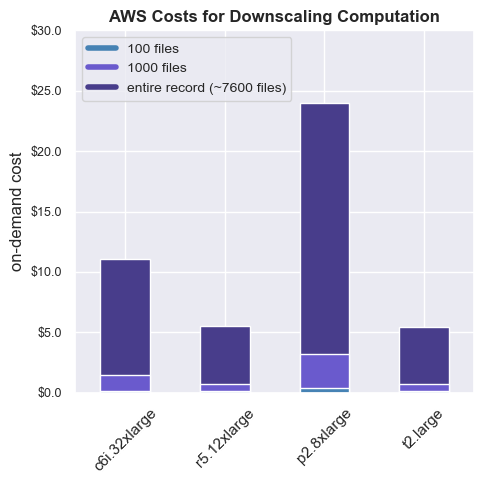

In [102]:
fig2 = plt.figure(figsize=(5, 5), layout='tight')
ax2 = plt.axes()

barcolors = ['darkslateblue', 'slateblue', 'steelblue']
compcosts_est.loc[ec2types, 'entire record (~7600 files)'].plot(kind='bar', color=barcolors[0], ax=ax2)
compcosts_est.loc[ec2types, '1000 files'].plot(kind='bar', color=barcolors[1], ax=ax2)
compcosts_est.loc[ec2types, '100 files'].plot(kind='bar', color=barcolors[2], ax=ax2)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=barcolors[2], lw=4),
                Line2D([0], [0], color=barcolors[1], lw=4),
                Line2D([0], [0], color=barcolors[0], lw=4)]

ax2.legend(custom_lines, compcosts_est.columns, loc='upper left', fontsize=10)

ax2.tick_params(axis='x', which='major', rotation=45)
ax2.set_title('AWS Costs for Downscaling Computation', fontsize=12, fontweight='bold')
ax2.set_ylabel('on-demand cost', fontsize=12)
_ = ax2.set_yticks(ax2.get_yticks())
_ = ax2.set_yticklabels(["$" + str(l) for l in ax2.get_yticks()])
ax2.tick_params(axis='y', which='major', labelsize=9)


fig2.savefig("aws-costs_downscale-comp.jpg")

### General Pricing Considerations

This analysis uses the EC2 on-demand pricing table at https://aws.amazon.com/ec2/pricing/on-demand/ (data taken on July 6, 2023). 

In [14]:
# Load data:
pricing = pd.read_csv('Amazon_EC2_On-Demand_Pricing.csv')

In [23]:
pricing.head(10)

,Instance name,On-Demand hourly rate,vCPU,Memory,Storage,Network performance
0,a1.medium,$0.03,1,2 GiB,EBS Only,Up to 10 Gigabit
1,a1.large,$0.05,2,4 GiB,EBS Only,Up to 10 Gigabit
2,a1.xlarge,$0.10,4,8 GiB,EBS Only,Up to 10 Gigabit
3,a1.2xlarge,$0.20,8,16 GiB,EBS Only,Up to 10 Gigabit
4,a1.4xlarge,$0.41,16,32 GiB,EBS Only,Up to 10 Gigabit
5,a1.metal,$0.41,16,32 GiB,EBS Only,Up to 10 Gigabit
6,t4g.nano,$0.00,2,0.5 GiB,EBS Only,Up to 5 Gigabit
7,t4g.micro,$0.01,2,1 GiB,EBS Only,Up to 5 Gigabit
8,t4g.small,$0.02,2,2 GiB,EBS Only,Up to 5 Gigabit
9,t4g.medium,$0.03,2,4 GiB,EBS Only,Up to 5 Gigabit


In [32]:
# Convert the hourly rates column to float-type:
pricing['hourly rate float'] = pricing['On-Demand hourly rate'].apply(lambda x: float(x[1:]))

# Get the instance type prefixes as a new column:
pricing['Instance name prefix'] = pricing['Instance name'].apply(lambda x: x.split('.')[0])

(-5.0, 45.0)

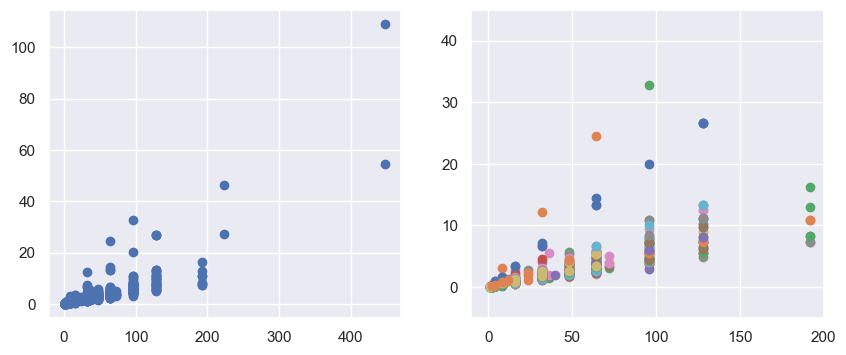

In [37]:
fig3, axes3 = plt.subplots(1, 2, figsize=(10,4))

axes3[0].scatter(pricing['vCPU'], pricing['hourly rate float'])
#axes3[1].scatter(pricing['vCPU'], pricing['hourly rate float'])
for pref, data in pricing.groupby('Instance name prefix'):
    axes3[1].scatter(data['vCPU'], data['hourly rate float'])


#pricing.plot.scatter('vCPU', 'hourly rate float', c='Instance name prefix', ax=axes3[1])

axes3[1].set_xlim(-10, 200)
axes3[1].set_ylim(-5, 45)

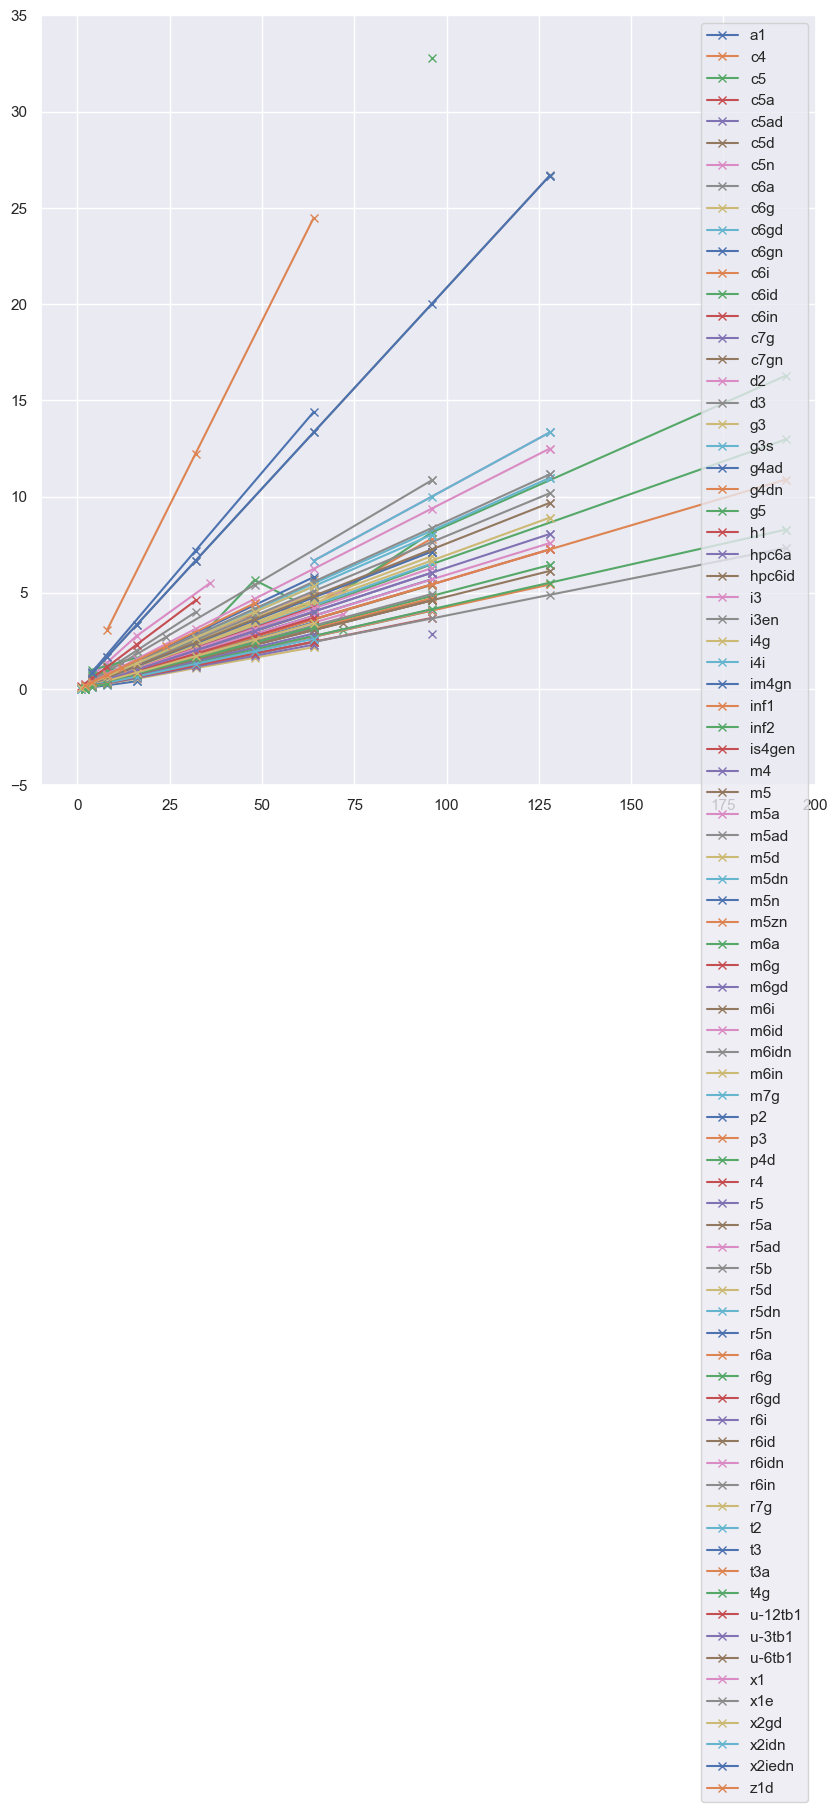

In [45]:
fig4 = plt.figure(figsize=(10,10))
ax4 = plt.axes()


#axes3[1].scatter(pricing['vCPU'], pricing['hourly rate float'])
for pref, data in pricing.groupby('Instance name prefix'):
    #ax4.scatter(data['vCPU'], data['hourly rate float'])
    ax4.plot(data['vCPU'], data['hourly rate float'], 'x-', label=pref)


#pricing.plot.scatter('vCPU', 'hourly rate float', c='Instance name prefix', ax=axes3[1])

ax4.set_xlim(-10, 200)
ax4.set_ylim(-5, 35)

ax4.legend()